# 目的

single agent, multi agent, openai assistantで同じタスクを実行してアウトプットの違いを比較したい。

- 複雑なタスクのほうが違いが出やすいと思われる。singleではプロンプトが膨らんでいき、ノイズが多いと応答の質も悪くなりそう。
- multi agentでもstateをすべて共有するか、結果だけ共有するかで結果が変わる。今回は後者の検証。
- assistantsはsingle agentと近い設計だが、FWをかますことでプロンプトに違いが出そう。そもそもassistant専用のAPIを叩いているのでchatと別物。

どんなタスクを検証するか。
- toolを使う前提で、かつtool(関数)の結果が大きい
- あとは単純だがステップ数が多いタスクで、伝言ゲームみたいに途中でデータが変わったり、目的を見失ったりしないか

方針
- まずそれぞれミニマムで組む
- tool呼び出しは共通のモックデータを返す

関数定義
- 店舗取得: 店舗IDを渡すと店舗情報（id, 店舗名, 都道府県, 会社id）を返す
- 会社取得: 会社IDを渡すと会社情報（id, 会社名, 店舗数）を返す
- 口コミ取得: 店舗IDを渡すと口コミ（店舗id, comment, review_name）一覧500件を返す
- 売り上げ取得: 店舗IDを渡すと店舗売り上げ（店舗id, 日付, 売り上げ）を直近365日分返す

## 関数定義

In [10]:
import random
from datetime import datetime, timedelta
from typing import List, Dict, Any

# 店舗評価取得
# 店舗IDごとの評価（1~5点）を100店舗分返す
def get_company_ratings() -> List[Dict[str, Any]]:
    return [{"company_id": i, "rating": 5 if i == 1 else ((i % 3) + 1)} for i in range(1, 101)]

# 店舗取得
# 会社IDを指定すると、会社が経営している全店舗情報を返す（店舗ID, 店舗名, 都道府県, 会社ID）
def get_stores(company_id: int) -> Dict[str, Any]:
    return [
        {"store_id": 1, "name": "ラーメン一番", "prefecture": "東京都", "company_id": 1},
        {"store_id": 2, "name": "寿司太郎", "prefecture": "大阪府", "company_id": 1},
        {"store_id": 3, "name": "焼肉キング", "prefecture": "福岡県", "company_id": 1},
    ]
    return store_data.get(store_id, {})

# 会社取得
# 会社IDを指定すると、会社情報（会社ID, 会社名, 店舗数）を返す

def get_company_info(company_id: int) -> Dict[str, Any]:
    if company_id == 1:
        return {"company_id": 1, "name": "グルメフーズ株式会社", "store_count": 3}
    return {}

# 口コミ取得
# 店舗IDを指定すると、その店舗の口コミ一覧を返す（500件）
def get_store_reviews(store_id: int) -> List[Dict[str, Any]]:
    if store_id == 1:
        comments = [
            "接客態度が悪かった", "店員の対応が冷たい", "サービスが悪い", "注文を間違えられた", "待ち時間が長すぎる",
            "愛想がなかった", "清潔感がない", "店内がうるさい", "価格が高い割にサービスが悪い", "二度と行きたくない"
        ]
        return [{"store_id": store_id, "comment": random.choice(comments), "review_name": f"user_{i}"} for i in range(1, 251)]
    
    if store_id == 2:
        comments = [
            "料理がとても美味しかった", "味が絶品だった", "また来たいと思った", "食材が新鮮だった", "コスパが良かった",
            "雰囲気が最高だった", "シェフの腕が素晴らしい", "デザートまで完璧だった", "量もちょうど良い", "家族で楽しめた"
        ]
        return [{"store_id": store_id, "comment": random.choice(comments), "review_name": f"user_{i}"} for i in range(1, 251)]
    
    return []

# 売り上げ取得
# 店舗IDを指定すると、直近365日分の売り上げデータを返す

def get_store_sales(store_id: int) -> List[Dict[str, Any]]:
    start_date = datetime.today() - timedelta(days=365)
    sales_data = []
    for i in range(365):
        date = start_date + timedelta(days=i)
        if store_id == 1:
            sales = max(1000 - (i * 2), 100)  # 売上が急激に下がる
        elif store_id == 2:
            sales = min(100 + (i * 3), 5000)  # 売上が急激に上がる
        elif store_id == 3:
            sales = 2000  # 売上は一定
        else:
            return []
        sales_data.append({"store_id": store_id, "date": date.strftime('%Y-%m-%d'), "sales": sales})
    return sales_data

## single agent

In [39]:
import uuid
import json
from typing import Annotated, Literal, List, Optional
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command
from typing_extensions import TypedDict
from IPython.display import Image, display
from datetime import datetime, timedelta
import random

@tool
def get_company_ratings() -> List[Dict[str, Any]]:
    """
    Retrieve company ratings for 100 companies.

    Returns:
        List[Dict[str, Any]]: A list of company ratings with company_id and rating.
    """
    print("Function: get_company_ratings, Args: None")
    return [{"company_id": i, "rating": 5 if i == 1 else ((i % 3) + 1)} for i in range(1, 101)]

@tool
def get_stores(company_id: int) -> List[Dict[str, Any]]:
    """
    Fetch all stores operated by a specific company.

    Args:
        company_id (int): The ID of the company.

    Returns:
        List[Dict[str, Any]]: A list of store details.
    """
    print(f"Function: get_stores, Args: company_id={company_id}")
    return [
        {"store_id": 1, "name": "ラーメン一番", "prefecture": "東京都", "company_id": 1},
        {"store_id": 2, "name": "寿司太郎", "prefecture": "大阪府", "company_id": 1},
        {"store_id": 3, "name": "焼肉キング", "prefecture": "福岡県", "company_id": 1},
    ]

@tool
def get_company_info(company_id: int) -> Dict[str, Any]:
    """
    Retrieve company details based on company ID.

    Args:
        company_id (int): The ID of the company.

    Returns:
        Dict[str, Any]: Company information.
    """
    print(f"Function: get_company_info, Args: company_id={company_id}")
    if company_id == 1:
        return {"company_id": 1, "name": "グルメフーズ株式会社", "store_count": 3}
    return {}

@tool
def get_store_reviews(store_id: int) -> List[Dict[str, Any]]:
    """
    Fetch customer reviews for a specific store.

    Args:
        store_id (int): The store ID.

    Returns:
        List[Dict[str, Any]]: A list of reviews.
    """
    print(f"Function: get_store_reviews, Args: store_id={store_id}")
    comments = {
        1: [
            "接客態度が悪かった", "店員の対応が冷たい", "サービスが悪い", "注文を間違えられた", "待ち時間が長すぎる",
            "愛想がなかった", "清潔感がない", "店内がうるさい", "価格が高い割にサービスが悪い", "二度と行きたくない"
        ],
        2: [
            "料理がとても美味しかった", "味が絶品だった", "また来たいと思った", "食材が新鮮だった", "コスパが良かった",
            "雰囲気が最高だった", "シェフの腕が素晴らしい", "デザートまで完璧だった", "量もちょうど良い", "家族で楽しめた"
        ]
    }
    
    return [{"store_id": store_id, "comment": random.choice(comments.get(store_id, ["レビューなし"])), "review_name": f"user_{i}"} for i in range(1, 251)]

@tool
def get_store_sales(store_id: int) -> List[Dict[str, Any]]:
    """
    Retrieve sales data for the past 365 days for a specific store.

    Args:
        store_id (int): The store ID.

    Returns:
        List[Dict[str, Any]]: A list of daily sales data.
    """
    print(f"Function: get_store_sales, Args: store_id={store_id}")
    start_date = datetime.today() - timedelta(days=365)
    sales_data = []
    for i in range(365):
        date = start_date + timedelta(days=i)
        if store_id == 1:
            sales = max(1000 - (i * 2), 100)
        elif store_id == 2:
            sales = min(100 + (i * 3), 5000)
        elif store_id == 3:
            sales = 2000
        else:
            return []
        sales_data.append({"store_id": store_id, "date": date.strftime('%Y-%m-%d'), "sales": sales})
    return sales_data

In [57]:
class SingleAgent:
    def __init__(self, model_name: str):
        """
        Initialize SingleAgent with the given model name.
        """
        self.model_name = model_name
        self.llm = ChatOpenAI(model=model_name, temperature=0)
        
        # Define tools
        self.tools = [get_company_ratings, get_stores, get_company_info, get_store_reviews, get_store_sales]
        self.llm_with_tools = self.llm.bind_tools(self.tools)
        
        # Define graph
        self.graph_builder = StateGraph(State)
        self.graph_builder.add_node("chatbot", self.chatbot)
        tool_node = ToolNode(tools=self.tools)
        self.graph_builder.add_node("tools", tool_node)
        self.graph_builder.add_conditional_edges("chatbot", tools_condition)
        self.graph_builder.add_edge("tools", "chatbot")
        self.graph_builder.add_edge(START, "chatbot")
        
        # Compile graph
        self.thread_id = uuid.uuid4()
        self.memory = MemorySaver()
        self.graph = self.graph_builder.compile(checkpointer=self.memory)
    
    def chatbot(self, state: State):
        """
        Process chatbot response.
        """
        message = self.llm_with_tools.invoke(state["messages"])
        return {"messages": [message]}
    
    def run(self, command: str) -> str:
        """
        Execute the chatbot and return the response as a string.
        """
        config = {"configurable": {"thread_id": self.thread_id}}
            
        result = self.graph.invoke(
            {"messages": [{"role": "user", "content": command}]},
            config,
            stream_mode="values",
        )
        return result

        # events = self.graph.stream(
        #     {"messages": [{"role": "user", "content": command}]},
        #     config,
        #     stream_mode="values",
        # )
        # for event in events:
        #     if "messages" in event:
        #         return event["messages"][-1]
        # return result['messages'][-1].content

In [54]:
single_agent = SingleAgent("gpt-4o-mini")
result = single_agent.run("こんにちは、あなたの機能を教えてください。")
print(result)

{'messages': [AIMessage(content='こんにちは！私はさまざまな情報を提供するための機能を持っています。具体的には、以下のことができます：\n\n1. **企業の評価を取得**: 100社の企業の評価を取得できます。\n2. **企業の店舗情報を取得**: 特定の企業が運営する店舗の情報を取得できます。\n3. **企業の詳細情報を取得**: 企業IDに基づいて企業の詳細情報を取得できます。\n4. **店舗の顧客レビューを取得**: 特定の店舗に対する顧客のレビューを取得できます。\n5. **店舗の売上データを取得**: 特定の店舗の過去365日間の売上データを取得できます。\n\n何か特定の情報が必要でしたら、お知らせください！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 180, 'prompt_tokens': 282, 'total_tokens': 462, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-dd670bfa-2d17-4faa-b4ac-c5a3a0a3b586-0', usage_metadata={'input_tokens': 282, 'output_tokens': 180, 'total_tokens': 462, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_t

In [55]:
result['messages'][-1].content

'こんにちは！私はさまざまな情報を提供するための機能を持っています。具体的には、以下のことができます：\n\n1. **企業の評価を取得**: 100社の企業の評価を取得できます。\n2. **企業の店舗情報を取得**: 特定の企業が運営する店舗の情報を取得できます。\n3. **企業の詳細情報を取得**: 企業IDに基づいて企業の詳細情報を取得できます。\n4. **店舗の顧客レビューを取得**: 特定の店舗に対する顧客のレビューを取得できます。\n5. **店舗の売上データを取得**: 特定の店舗の過去365日間の売上データを取得できます。\n\n何か特定の情報が必要でしたら、お知らせください！'

In [56]:
result = single_agent.run("""
次の指示に従い、企業の口コミを分析して結果をレポートにまとめてください。
1. 全企業で最も評価が高い企業を分析の対象とします
2. 対象の売上を調べ、売上が好調な店舗と不調な店舗をそれぞれ1店舗ずつ抽出します
3. 抽出した店舗の口コミを調べ、売上好調の理由と売上不調の理由をそれぞれ分析します
""")
print(result)

Function: get_company_ratings, Args: None


BadRequestError: Error code: 400 - {'error': {'message': "Invalid parameter: messages with role 'tool' must be a response to a preceeding message with 'tool_calls'.", 'type': 'invalid_request_error', 'param': 'messages.[0].role', 'code': None}}

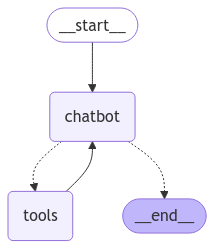

In [61]:
import uuid
import json
from typing import Annotated, Literal, List, Optional
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command
from typing_extensions import TypedDict
from IPython.display import Image, display
from datetime import datetime, timedelta
import random

@tool
def get_company_ratings() -> List[Dict[str, Any]]:
    """
    Retrieve company ratings for 100 companies.

    Returns:
        List[Dict[str, Any]]: A list of company ratings with company_id and rating.
    """
    print("Function: get_company_ratings, Args: None")
    return [{"company_id": i, "rating": 5 if i == 1 else ((i % 3) + 1)} for i in range(1, 101)]

@tool
def get_stores(company_id: int) -> List[Dict[str, Any]]:
    """
    Fetch all stores operated by a specific company.

    Args:
        company_id (int): The ID of the company.

    Returns:
        List[Dict[str, Any]]: A list of store details.
    """
    print(f"Function: get_stores, Args: company_id={company_id}")
    return [
        {"store_id": 1, "name": "ラーメン一番", "prefecture": "東京都", "company_id": 1},
        {"store_id": 2, "name": "寿司太郎", "prefecture": "大阪府", "company_id": 1},
        {"store_id": 3, "name": "焼肉キング", "prefecture": "福岡県", "company_id": 1},
    ]

@tool
def get_company_info(company_id: int) -> Dict[str, Any]:
    """
    Retrieve company details based on company ID.

    Args:
        company_id (int): The ID of the company.

    Returns:
        Dict[str, Any]: Company information.
    """
    print(f"Function: get_company_info, Args: company_id={company_id}")
    if company_id == 1:
        return {"company_id": 1, "name": "グルメフーズ株式会社", "store_count": 3}
    return {}

@tool
def get_store_reviews(store_id: int) -> List[Dict[str, Any]]:
    """
    Fetch customer reviews for a specific store.

    Args:
        store_id (int): The store ID.

    Returns:
        List[Dict[str, Any]]: A list of reviews.
    """
    print(f"Function: get_store_reviews, Args: store_id={store_id}")
    comments = {
        1: [
            "接客態度が悪かった", "店員の対応が冷たい", "サービスが悪い", "注文を間違えられた", "待ち時間が長すぎる",
            "愛想がなかった", "清潔感がない", "店内がうるさい", "価格が高い割にサービスが悪い", "二度と行きたくない"
        ],
        2: [
            "料理がとても美味しかった", "味が絶品だった", "また来たいと思った", "食材が新鮮だった", "コスパが良かった",
            "雰囲気が最高だった", "シェフの腕が素晴らしい", "デザートまで完璧だった", "量もちょうど良い", "家族で楽しめた"
        ]
    }
    
    return [{"store_id": store_id, "comment": random.choice(comments.get(store_id, ["レビューなし"])), "review_name": f"user_{i}"} for i in range(1, 251)]

@tool
def get_store_sales(store_id: int) -> List[Dict[str, Any]]:
    """
    Retrieve sales data for the past 365 days for a specific store.

    Args:
        store_id (int): The store ID.

    Returns:
        List[Dict[str, Any]]: A list of daily sales data.
    """
    print(f"Function: get_store_sales, Args: store_id={store_id}")
    start_date = datetime.today() - timedelta(days=365)
    sales_data = []
    for i in range(365):
        date = start_date + timedelta(days=i)
        if store_id == 1:
            sales = max(1000 - (i * 2), 100)
        elif store_id == 2:
            sales = min(100 + (i * 3), 5000)
        elif store_id == 3:
            sales = 2000
        else:
            return []
        sales_data.append({"store_id": store_id, "date": date.strftime('%Y-%m-%d'), "sales": sales})
    return sales_data

tools = [get_company_ratings, get_stores, get_company_info, get_store_reviews, get_store_sales]

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)

class State(TypedDict):
    messages: Annotated[List, add_messages]


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # assert len(message.tool_calls) > 0, "No tool call"
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Exception:", e)

In [62]:
user_input = """
次の指示に従い、企業の口コミを分析して結果をレポートにまとめてください。
1. 全企業で最も評価が高い企業を分析の対象とします
2. 対象の売上を調べ、売上が好調な店舗と不調な店舗をそれぞれ1店舗ずつ抽出します
3. 抽出した店舗の口コミを調べ、売上好調の理由と売上不調の理由をそれぞれ分析します
"""
config = {"configurable": {"thread_id": "2"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================


次の指示に従い、企業の口コミを分析して結果をレポートにまとめてください。
1. 全企業で最も評価が高い企業を分析の対象とします
2. 対象の売上を調べ、売上が好調な店舗と不調な店舗をそれぞれ1店舗ずつ抽出します
3. 抽出した店舗の口コミを調べ、売上好調の理由と売上不調の理由をそれぞれ分析します

================================== Ai Message ==================================
Tool Calls:
  get_company_ratings (call_j9ro5pXgYEwhWIHI3oJtJLm2)
 Call ID: call_j9ro5pXgYEwhWIHI3oJtJLm2
  Args:
Function: get_company_ratings, Args: None
================================= Tool Message =================================
Name: get_company_ratings

[{"company_id": 1, "rating": 5}, {"company_id": 2, "rating": 3}, {"company_id": 3, "rating": 1}, {"company_id": 4, "rating": 2}, {"company_id": 5, "rating": 3}, {"company_id": 6, "rating": 1}, {"company_id": 7, "rating": 2}, {"company_id": 8, "rating": 3}, {"company_id": 9, "rating": 1}, {"company_id": 10, "rating": 2}, {"company_id": 11, "rating": 3}, {"company_id": 12, "rating": 1}, {"company_id": 13, "rating": 2}, {

In [58]:
user_input = "評価の高い店舗の売り上げを分析し、特に売り上げが高かった時期の料理に関する口コミを収集し、高評価の要因を予測してください"
config = {"configurable": {"thread_id": "2"}}

events = single_agent.graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

AttributeError: 'dict' object has no attribute 'pretty_print'